In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import compute_sample_weight

# Load feature matrix
df = pd.read_csv('../data/features_2022_2025.csv')

print(f"Dataset: {df.shape}")
print(f"Years: {df['Year'].unique()}")

Dataset: (1838, 28)
Years: [2022 2023 2024 2025]


In [2]:
# Features we'll use for prediction
feature_cols = [
    'GridPosition',
    'QualiPosition',
    'QualiGapToPole',
    'AvgFinishLast5',
    'AvgQualiLast5',
    'PointsLast3',
    'ConstructorAvgFinishLast3',
    'ConstructorPodiumRateSeason',
    'DriverCircuitAvgFinish',
    'DNFRateSeason',
    'PodiumRateSeason',
    'ConstructorChampPos',
]

# Target: finish position
target = 'Position'

# Remove any rows with missing data in features or target
df_clean = df.dropna(subset=feature_cols + [target])

print(f"Clean dataset: {df_clean.shape}")
print(f"Dropped {len(df) - len(df_clean)} rows with missing values")

Clean dataset: (1786, 28)
Dropped 52 rows with missing values


In [3]:
# CRITICAL: Never train on future data to predict past
# This is a time-series problem, not random data

train = df_clean[df_clean['Year'].isin([2022, 2023])]
val   = df_clean[df_clean['Year'] == 2024]
test  = df_clean[df_clean['Year'] == 2025]

X_train, y_train = train[feature_cols], train[target]
X_val,   y_val   = val[feature_cols],   val[target]
X_test,  y_test  = test[feature_cols],  test[target]

print("Dataset splits:")
print(f"  Train (2022-2023): {len(X_train)} rows")
print(f"  Val   (2024):      {len(X_val)} rows")
print(f"  Test  (2025):      {len(X_test)} rows")

Dataset splits:
  Train (2022-2023): 845 rows
  Val   (2024):      473 rows
  Test  (2025):      468 rows


In [4]:
# Give more weight to recent seasons
# 2026 will have new regulations, so 2025 is most relevant

def get_sample_weights(df):
    """
    Weight training samples by recency
    2023 = 3x weight (most recent full season before reg changes)
    2022 = 1x weight (older, less relevant)
    """
    weights = []
    for year in df['Year']:
        if year == 2023:
            weights.append(3.0)
        elif year == 2022:
            weights.append(1.0)
    return np.array(weights)

sample_weights = get_sample_weights(train)

print("Sample weight distribution:")
print(f"  2022 races: weight = 1.0")
print(f"  2023 races: weight = 3.0")
print(f"  Total effective samples: {sample_weights.sum():.0f}")

Sample weight distribution:
  2022 races: weight = 1.0
  2023 races: weight = 3.0
  Total effective samples: 1709


In [6]:
# XGBoost Regressor — predict finish position (1-20)
# Then we'll rank predictions to get podium

model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mae',
    early_stopping_rounds=30  # Move it here as a parameter
)

print("Training model...")

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=50
)

print("\n✅ Training complete")

Training model...
[0]	validation_0-mae:4.85776
[50]	validation_0-mae:3.02089
[100]	validation_0-mae:3.01856
[108]	validation_0-mae:3.01943

✅ Training complete


                        Feature  Importance
1                 QualiPosition    0.196519
5                   PointsLast3    0.118463
4                 AvgQualiLast5    0.114956
10             PodiumRateSeason    0.104067
7   ConstructorPodiumRateSeason    0.097945
11          ConstructorChampPos    0.070153
8        DriverCircuitAvgFinish    0.062342
0                  GridPosition    0.054833
2                QualiGapToPole    0.054649
9                 DNFRateSeason    0.046046
6     ConstructorAvgFinishLast3    0.044448
3                AvgFinishLast5    0.035579


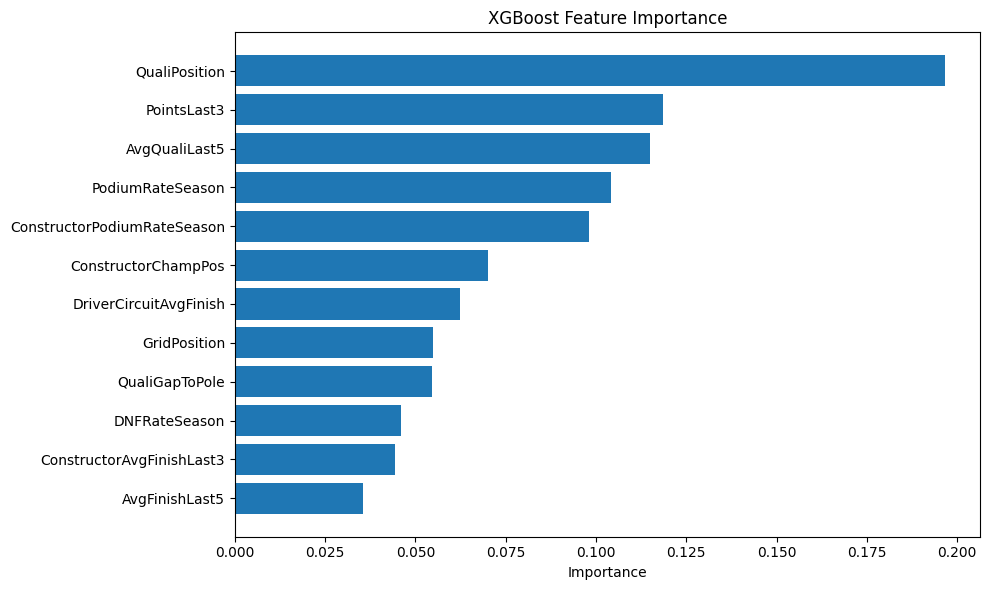

In [7]:
# Which features does the model rely on most?

importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Mean Absolute Error: average positions off by

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Mean Absolute Error (positions):")
print(f"  Validation (2024): {mae_val:.2f}")
print(f"  Test (2025):       {mae_test:.2f}")
print(f"\nBaseline (always predict grid position): {mean_absolute_error(y_val, val['GridPosition']):.2f}")

Mean Absolute Error (positions):
  Validation (2024): 2.98
  Test (2025):       3.29

Baseline (always predict grid position): 2.90


In [9]:
def evaluate_podium_predictions(model, df_subset, feature_cols):
    """
    For each race, predict top 3 finishers and compare to actual podium
    """
    results = []
    
    for (year, race_num), race in df_subset.groupby(['Year', 'RaceNumber']):
        X_race = race[feature_cols]
        preds = model.predict(X_race)
        
        race = race.copy()
        race['PredictedPosition'] = preds
        
        # Predicted podium: top 3 by predicted position
        predicted_podium = set(
            race.nsmallest(3, 'PredictedPosition')['Abbreviation']
        )
        
        # Actual podium
        actual_podium = set(
            race[race['Position'] <= 3]['Abbreviation']
        )
        
        # How many did we get right?
        overlap = len(predicted_podium & actual_podium)
        
        results.append({
            'year': year,
            'race': race_num,
            'event': race['EventName'].iloc[0],
            'correct_drivers': overlap,
            'perfect': overlap == 3,
            'predicted': list(predicted_podium),
            'actual': list(actual_podium)
        })
    
    return pd.DataFrame(results)

# Evaluate on validation set
val_results = evaluate_podium_predictions(model, val, feature_cols)

print("=== 2024 Validation Results ===")
print(f"Average correct drivers per race: {val_results['correct_drivers'].mean():.2f} / 3")
print(f"Perfect podiums: {val_results['perfect'].mean():.1%}")
print(f"\nBaseline (always pick top-3 qualifiers):")
print(f"  Average correct: ~1.5 / 3")
print(f"  Perfect podiums: ~10%")

# Show some examples
print("\nSample predictions:")
print(val_results[['event', 'correct_drivers', 'predicted', 'actual']].head(10))

=== 2024 Validation Results ===
Average correct drivers per race: 1.71 / 3
Perfect podiums: 12.5%

Baseline (always pick top-3 qualifiers):
  Average correct: ~1.5 / 3
  Perfect podiums: ~10%

Sample predictions:
                       event  correct_drivers        predicted  \
0         Bahrain Grand Prix                1  [RUS, LEC, VER]   
1   Saudi Arabian Grand Prix                3  [PER, LEC, VER]   
2      Australian Grand Prix                1  [PER, LEC, VER]   
3        Japanese Grand Prix                2  [SAI, PER, LEC]   
4         Chinese Grand Prix                2  [PER, LEC, VER]   
5           Miami Grand Prix                2  [NOR, PER, LEC]   
6  Emilia Romagna Grand Prix                3  [NOR, LEC, VER]   
7          Monaco Grand Prix                2  [NOR, PIA, LEC]   
8        Canadian Grand Prix                3  [NOR, RUS, VER]   
9         Spanish Grand Prix                2  [NOR, LEC, VER]   

            actual  
0  [PER, SAI, VER]  
1  [PER, LEC, VER]

In [10]:
# Final evaluation on held-out 2025 data

test_results = evaluate_podium_predictions(model, test, feature_cols)

print("=== 2025 Test Results ===")
print(f"Average correct drivers: {test_results['correct_drivers'].mean():.2f} / 3")
print(f"Perfect podiums: {test_results['perfect'].mean():.1%}")

# Distribution of correct predictions
print("\nPrediction accuracy distribution:")
print(test_results['correct_drivers'].value_counts().sort_index())

# Show all 2025 races
print("\n2025 Season Predictions:")
print(test_results[['event', 'correct_drivers', 'predicted', 'actual']].to_string(index=False))

=== 2025 Test Results ===
Average correct drivers: 1.79 / 3
Perfect podiums: 12.5%

Prediction accuracy distribution:
correct_drivers
1     8
2    13
3     3
Name: count, dtype: int64

2025 Season Predictions:
                    event  correct_drivers       predicted          actual
    Australian Grand Prix                2 [NOR, LEC, VER] [NOR, VER, RUS]
       Chinese Grand Prix                2 [NOR, VER, RUS] [NOR, PIA, RUS]
      Japanese Grand Prix                1 [NOR, ANT, RUS] [NOR, PIA, VER]
       Bahrain Grand Prix                2 [NOR, PIA, VER] [NOR, PIA, RUS]
 Saudi Arabian Grand Prix                1 [NOR, PIA, RUS] [PIA, LEC, VER]
         Miami Grand Prix                2 [NOR, PIA, VER] [NOR, PIA, RUS]
Emilia Romagna Grand Prix                2 [NOR, PIA, RUS] [NOR, PIA, VER]
        Monaco Grand Prix                3 [NOR, PIA, LEC] [NOR, PIA, LEC]
       Spanish Grand Prix                2 [NOR, PIA, RUS] [NOR, PIA, LEC]
      Canadian Grand Prix               

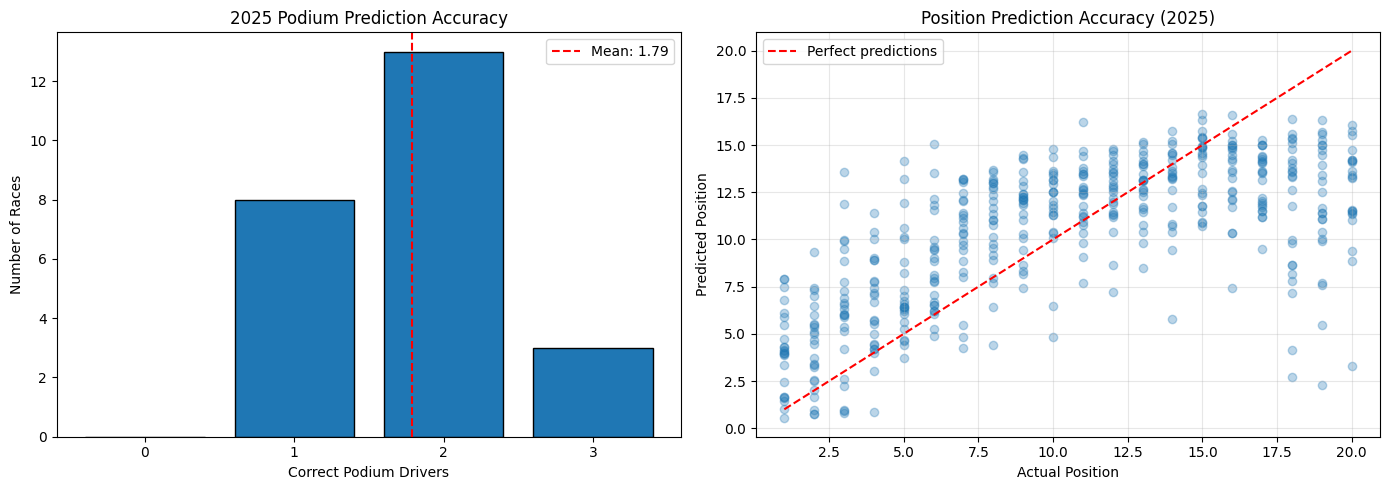

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Correct drivers per race
axes[0].hist(test_results['correct_drivers'], bins=[0, 1, 2, 3, 4], 
             edgecolor='black', align='left', rwidth=0.8)
axes[0].set_xlabel('Correct Podium Drivers')
axes[0].set_ylabel('Number of Races')
axes[0].set_title('2025 Podium Prediction Accuracy')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].axvline(test_results['correct_drivers'].mean(), 
                color='red', linestyle='--', 
                label=f"Mean: {test_results['correct_drivers'].mean():.2f}")
axes[0].legend()

# Right: Predicted vs Actual Position
axes[1].scatter(y_test, y_test_pred, alpha=0.3)
axes[1].plot([1, 20], [1, 20], 'r--', label='Perfect predictions')
axes[1].set_xlabel('Actual Position')
axes[1].set_ylabel('Predicted Position')
axes[1].set_title('Position Prediction Accuracy (2025)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Save trained model for race predictions
import os
os.makedirs('../models', exist_ok=True)

joblib.dump(model, '../models/xgb_f1_podium_predictor.pkl')

# Also save feature list so we know exactly what the model expects
with open('../models/feature_list.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print("✅ Model saved to ../models/xgb_f1_podium_predictor.pkl")
print("✅ Feature list saved to ../models/feature_list.txt")

✅ Model saved to ../models/xgb_f1_podium_predictor.pkl
✅ Feature list saved to ../models/feature_list.txt


In [13]:
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nMean Absolute Error:")
print(f"  2024 validation: {mae_val:.2f} positions")
print(f"  2025 test:       {mae_test:.2f} positions")

print(f"\nPodium Prediction Accuracy:")
print(f"  2024: {val_results['correct_drivers'].mean():.2f}/3 drivers correct")
print(f"  2025: {test_results['correct_drivers'].mean():.2f}/3 drivers correct")

print(f"\nPerfect Podiums:")
print(f"  2024: {val_results['perfect'].sum()}/{len(val_results)} races ({val_results['perfect'].mean():.1%})")
print(f"  2025: {test_results['perfect'].sum()}/{len(test_results)} races ({test_results['perfect'].mean():.1%})")

print(f"\nModel is ready for 2026 predictions!")
print("="*60)

MODEL PERFORMANCE SUMMARY

Mean Absolute Error:
  2024 validation: 2.98 positions
  2025 test:       3.29 positions

Podium Prediction Accuracy:
  2024: 1.71/3 drivers correct
  2025: 1.79/3 drivers correct

Perfect Podiums:
  2024: 3/24 races (12.5%)
  2025: 3/24 races (12.5%)

Model is ready for 2026 predictions!


In [17]:
print("="*60)
print("RETRAINING ON ALL DATA FOR 2026 PREDICTIONS")
print("="*60)

# Use all data (2022-2025) for final model
train_all = df_clean[df_clean['Year'].isin([2022, 2023, 2024, 2025])]
X_train_all, y_train_all = train_all[feature_cols], train_all[target]

# Heavy weight on recent seasons
def get_sample_weights_all(df):
    weights = []
    for year in df['Year']:
        if year == 2025:
            weights.append(10.0)
        elif year == 2024:
            weights.append(5.0)
        elif year == 2023:
            weights.append(2.0)
        elif year == 2022:
            weights.append(1.0)
    return np.array(weights)

sample_weights_all = get_sample_weights_all(train_all)

print(f"Training samples: {len(X_train_all)}")
print(f"Effective weight: {sample_weights_all.sum():.0f}")

# Train final model (no early stopping since we're using all data)
model_2026 = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mae'
    # No early_stopping_rounds - we're using all data
)

model_2026.fit(X_train_all, y_train_all, sample_weight=sample_weights_all)

RETRAINING ON ALL DATA FOR 2026 PREDICTIONS
Training samples: 1786
Effective weight: 8322


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [18]:
import os
print("Files in models folder:")
print(os.listdir('../models'))

Files in models folder:
['feature_list.txt', 'xgb_f1_podium_predictor.pkl']


In [19]:
import joblib
import os

# Check current directory
print(f"Current directory: {os.getcwd()}")

# Check if models folder exists
print(f"Models folder exists: {os.path.exists('../models')}")

# List what's in models folder
if os.path.exists('../models'):
    print(f"Files in models: {os.listdir('../models')}")

# Manually save the model
print("\nManually saving model...")
joblib.dump(model_2026, '../models/xgb_f1_2026_final.pkl')
print("✅ Saved!")

# Verify it saved
print(f"File exists now: {os.path.exists('../models/xgb_f1_2026_final.pkl')}")

Current directory: /Users/bpark/Desktop/F1 2026 Prediction Model/f1_2026_predictions/notebooks
Models folder exists: True
Files in models: ['feature_list.txt', 'xgb_f1_podium_predictor.pkl']

Manually saving model...
✅ Saved!
File exists now: True
